# 5일차 과제 : RF 랜덤포레스트

 sklearn의 GridSearchCV 함수를 사용해 최적의 매개변수들을 구하고, 
 
 최종 랜덤포레스트 모델을 만들고 해석하라.
 
 데이터 : 유방암 데이터(변수: 31개, 자료 수: 569개)
 
 -.목표변수(diagnosis, 0: Malignant(악성,212개), 1: Benign(양성,357개)

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore') #경고 무시

In [4]:
ds_bc = pd.read_csv('/home/pirl/Downloads/week4day1/유방암.csv',engine='python')
ds_bc.info()

#설명변수 X_i는 30개
#종속변수 Y는 이산형(1은 양성, 0은 악성)이지만 실제 분석에서는 연속형으로 처리
#결측치는 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

In [10]:
def remove_outlier_std(df):
    for i in range(0, len(df.iloc[1])):
        df = df[(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) < (3.6*df.iloc[:,i].std()))]
    return df
#3.6sigma를 벗어나는 data제거 함수

ds_bc_z=remove_outlier_std(ds_bc)
ds_bc_z.info()
#494개로 이상치 제거
#랜덤포레스트 알고리즘 특성상 이상치를 크게 신경쓰지 않아도 되지만
#data의 분포가 전반적으로 UCL을 초과하는 경향이 강하고
#모델의 일반성, 범용성을 위해 이상치 제거 실시

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 1 to 568
Data columns (total 31 columns):
diagnosis                  494 non-null int64
mean radius                494 non-null float64
mean texture               494 non-null float64
mean perimeter             494 non-null float64
mean area                  494 non-null float64
mean smoothness            494 non-null float64
mean compactness           494 non-null float64
mean concavity             494 non-null float64
mean concave points        494 non-null float64
mean symmetry              494 non-null float64
mean fractal dimension     494 non-null float64
radius error               494 non-null float64
texture error              494 non-null float64
perimeter error            494 non-null float64
area error                 494 non-null float64
smoothness error           494 non-null float64
compactness error          494 non-null float64
concavity error            494 non-null float64
concave points error       494 no

#  데이터 분할 7 : 3

In [11]:
ds_bc_y=ds_bc_z["diagnosis"]
ds_bc_x=ds_bc_z.drop("diagnosis",axis=1, inplace=False)
ds_bc_train_x, ds_bc_test_x, ds_bc_train_y, ds_bc_test_y = train_test_split(ds_bc_x,ds_bc_y,test_size=0.3, random_state=1234)
print("train data X size: {}".format(bc_train_x.shape))
print("train data Y size: {}".format(bc_train_y.shape))
print("test data X size: {}".format(bc_test_x.shape))
print("test data X size: {}".format(bc_test_y.shape))

train data X size: (345, 30)
train data Y size: (345,)
test data X size: (149, 30)
test data X size: (149,)


#  -------------------------------------------------------------------
# GridSearch/ cri= gini or entropy, depth:1~4,  leaf_size:5~9, #tree=1~14
#  -------------------------------------------------------------------

In [12]:
rf_uncustomized = RandomForestClassifier(random_state=123)
rf_uncustomized.fit(ds_bc_train_x, ds_bc_train_y)
# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(rf_uncustomized.score(ds_bc_train_x, ds_bc_train_y)))
# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(rf_uncustomized.score(ds_bc_test_x, ds_bc_test_y)))
# randomforest 모형 생성

Accucary on training set: 1.000
Accucary on test set: 0.933


In [13]:
parameters = {               
              'criterion': ['entropy', 'gini'],
              'max_depth': list(i for i in range(1,5)), 
              'min_samples_leaf': list(i for i in range(5,10)),
              'n_estimators' : list(i for i in range(1,15))
             }

grid_obj = GridSearchCV(rf_uncustomized, parameters)
grid_obj 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [1, 2, 3, 4], 'min_samples_leaf': [5, 6, 7, 8, 9], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# parameter에 criterion, max_depth, min_samples_leaf, n_estimators를 조정
# GridSearchCV 함수에 의해 grid_obj 에 param_grid로 
# 모형을 만들 parameter의 값들을 보여줌

In [14]:
grid_obj= grid_obj.fit(ds_bc_train_x, ds_bc_train_y)
searchcv = grid_obj.best_estimator_
searchcv.fit(ds_bc_train_x, ds_bc_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

# 위의 주어진 train data를 이용해 해당 parameter를 조합해서 모든 모형을 만듦
# best_estimator로 최적의 parameter를 return함
# best_estimator로 criterion=gini, max_depth=1, min_samples_leaf=5, n_estimators=5 로 알려줌
# 주어진 parameter에 train data로 모형을 만듦

In [15]:
predictions = searchcv.predict(bc_test_x)
print("Accuracy on test set:", accuracy_score(bc_test_y, predictions).round(3))

Accuracy on test set: 0.913


#  해당 모형에 test data로 예측
#  해당 예측치와 실제 test y data로 정확도를 계산
#  계산 결과 정확도 0.913

#  
# 정확도 0.913의 모델
# 동일 test data 기준으로는 더 높은 모형이 있을 수 있음

# train data를 기준으로 높은 정확도를 보여주는 parameter를 알려주기에
# test data에서도 최고값이라는 보장이 없음

# parameter들의 변경으로 더 높은 test 정확도의 모델이 존재할 수 있음

In [16]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = ds_bc_train_x.columns
ds_feature_importance["Importance"] = searchcv.feature_importances_
# ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance.sort_values("Importance", ascending=False).head(9)

,Feature,Importance
27,worst concave points,0.2
6,mean concavity,0.2
7,mean concave points,0.2
23,worst area,0.2
22,worst perimeter,0.2
0,mean radius,0.0
16,concavity error,0.0
28,worst symmetry,0.0
26,worst concavity,0.0


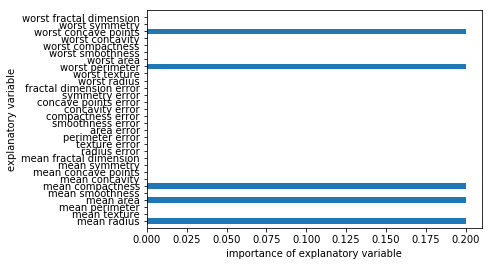

In [17]:
rf_model = RandomForestClassifier(criterion = "gini", max_depth= 1, min_samples_leaf = 5, \
                                  n_estimators = 5, random_state= 1234)
rf_model.fit(ds_bc_train_x, ds_bc_train_y)

feature_importance = pd.DataFrame()
feature_importance["feature"] = ds_bc_train_x.columns
feature_importance["importance"] = rf_model.feature_importances_
feature_importance.sort_values( by = "importance" , ascending = False)

# 설명변수 중요도 그래프 함수 정의
def plot_feature_importance(model):
    n_features = ds_bc_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_ , align= "center")
    plt.yticks(np.arange(n_features), ds_bc_train_x.columns)
    plt.xlabel("importance of explanatory variable")
    plt.ylabel("explanatory variable")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf_model)

# 5개 각각의 변수의 트리모형이므로
# 해당 변수의 1번 분기가 겹쳐진 모양


Grid_Search_Accuracy: 0.899


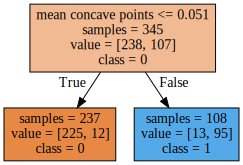

In [18]:
#트리모델 생성, criterion="gini",max_depth=1, min_sample_leaf=5 으로 모델 생성
tree = DecisionTreeClassifier(criterion="gini",max_depth=1,
                            min_samples_leaf=5,random_state=1234)
#tree model training
tree.fit(ds_bc_train_x,ds_bc_train_y)

print("Grid_Search_Accuracy: {0:.3f}".format(tree.score(ds_bc_test_x,ds_bc_test_y).round(3)))


export_graphviz(tree,out_file="tree.dot", class_names=["0","1"],
              feature_names=ds_bc_train_x.columns,impurity=False,filled=True)

os.environ["PATH"] += os.pathsep +""

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# RandomForest의 모델을 직접 표현할 수는 없지만
# 그래픽 편의를 보기 위해 DecisionTree 모델에 해당 parameter를 입력

#  -------------------------------------------------------------------------
# manual parameter 선택을 위한 랜덤포레스트 모형 생성
#  -------------------------------------------------------------------------

In [19]:
rf_uncustomized

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

# default: 트리의 수 n_estimators=10
# criterion='gini', min_samples_leaf=1

# 1. NumberofTree 트리의 수에 따른 정확도 변화: 1~30

In [20]:
#트리수 최대값:30;1~ 30까지 실행
n_iter_tree=30
#트레인 및 테스트 정확도 결과 저장용
train_accuracy = []
test_accuracy = []
#트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장

# 트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for n_tree in range(1, n_iter_tree):
    rf1 = RandomForestClassifier(n_estimators=n_tree,random_state=1234)
    rf1.fit(ds_bc_train_x,ds_bc_train_y)
    train_accuracy.append(rf1.score(ds_bc_train_x,ds_bc_train_y))
    test_accuracy.append(rf1.score(ds_bc_test_x,ds_bc_test_y))
    
#저장된 모델의 트레인/테스트 데이터 분류 정확도 테이블 생성
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["NumberofTree"]=[n_tree for n_tree in range(1,n_iter_tree)]
ds_accuracy1["TrainAccuracy"] =train_accuracy
ds_accuracy1["TestAccuracy"] =test_accuracy
ds_accuracy1.head(16)

,NumberofTree,TrainAccuracy,TestAccuracy
0,1,0.959420,0.899329
1,2,0.959420,0.879195
2,3,0.988406,0.932886
3,4,0.988406,0.912752
4,5,0.994203,0.932886
5,6,0.994203,0.912752
6,7,0.994203,0.919463
7,8,0.994203,0.932886
8,9,0.994203,0.932886
9,10,0.994203,0.939597


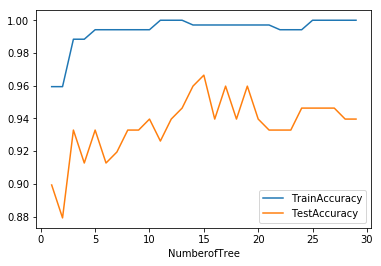

In [21]:
#테스트 결과
ds_accuracy1
#그래프 생성
ds_accuracy1.set_index("NumberofTree",inplace=False).plot.line()

# 15개 정도의 트리 갯수에서 높은 테스트 정확도를 보임

#  

# 2.Depth 깊이에 따라 : 1~15 by criterion

In [22]:
# train 및 test 정확도 결과 저장용
train_accuracy = []
test_accuracy = []
# 적용가능한 criterion: gini, entropy
para_max_depth = [i+1 for i in range(15)]*2
n_iter_depth = 15
# criterion 15개씩 리스트 생성
para_criterion = ["gini"]*n_iter_depth + ["entropy"] * n_iter_depth
# criterion: gini, entropy & max_depth: 1~30까지 반복 실행

for (criterion, depth) in zip(para_criterion,para_max_depth):
    rf3 = RandomForestClassifier(criterion = criterion,max_depth=depth, random_state=1234)
    rf3.fit(ds_bc_train_x, ds_bc_train_y)
    train_accuracy.append(rf3.score(ds_bc_train_x, ds_bc_train_y))
    test_accuracy.append(rf3.score(ds_bc_test_x, ds_bc_test_y))
# 저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3.head(7)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.921739,0.926174
1,gini,2,0.950725,0.932886
2,gini,3,0.979710,0.939597
3,gini,4,0.991304,0.959732
4,gini,5,0.994203,0.932886
5,gini,6,0.994203,0.932886
6,gini,7,0.994203,0.939597


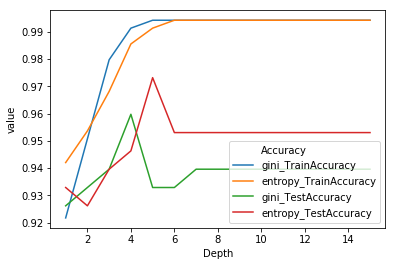

In [23]:
#그래프생성 
accuracy3_melt = pd.melt(ds_accuracy3, id_vars=["Criterion","Depth"])
accuracy3_melt["Accuracy"] = accuracy3_melt["Criterion"] + "_" + accuracy3_melt["variable"]
sns.lineplot( x= "Depth", y="value", hue ="Accuracy", data = accuracy3_melt)

# train :
# depth가 커질수록 정확도 증가 경향



# test :
# gini에서 depth가 4인 경우 높은 정확도에 비교적 단순한 모형

#  

# 3.min_samples_leaf 최소 잎 크기에 따라 : 1~69

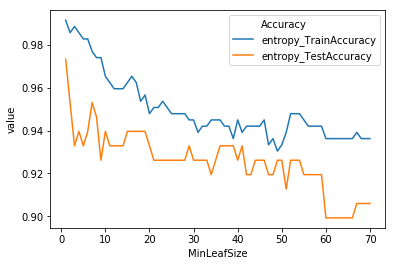

In [24]:
train_accuracy =[]; test_accuracy =[]

n_depth = 5
n_iter_min_leaf_size =70

para_criterion= ["entropy"] *n_iter_min_leaf_size
para_min_leaf_size = [i+1 for i in range(n_iter_min_leaf_size)]

for(criterion,leafsize) in zip(para_criterion, para_min_leaf_size):
    rf4 = RandomForestClassifier(criterion = criterion, max_depth = n_depth, min_samples_leaf = leafsize,random_state = 1234)
    rf4.fit(ds_bc_train_x, ds_bc_train_y)
    
    train_accuracy.append(rf4.score(ds_bc_train_x, ds_bc_train_y))
    test_accuracy.append(rf4.score(ds_bc_test_x, ds_bc_test_y))
accuracy4= pd.DataFrame()
accuracy4["Criterion"] = para_criterion
accuracy4["Depth"] = n_depth
accuracy4["MinLeafSize"] = para_min_leaf_size
accuracy4["TrainAccuracy"] = train_accuracy
accuracy4["TestAccuracy"] = test_accuracy
#그래프
accuracy4_melt = pd.melt(accuracy4, id_vars=["Criterion","Depth","MinLeafSize"])
accuracy4_melt["Accuracy"] = accuracy4_melt["Criterion"] + "_" + accuracy4_melt["variable"]
sns.lineplot( x= "MinLeafSize", y="value", hue ="Accuracy", data = accuracy4_melt)

# test 정확도는 다소 변동이 있어도
# min_leaf_size가 커질 수록 대체로 감소하는 경향
# min_leaf_size 낮아야 정확도가 상승 (1일수록 정확히 분류)
# 7~8정도에도 높은 test 정확도를 보임

#  ----------------------------------------------------------------------
# 최종 랜덤 포레스트 모형 : criterion="gini",max_depth=4, min_samples_leaf=6, n_estimators = 15을 선택
#  ----------------------------------------------------------------------

In [51]:
finalModel = RandomForestClassifier(criterion = "gini", max_depth = 4, 
                                    n_estimators = 15 , min_samples_leaf = 6, random_state = 1234)

In [54]:
finalModel.fit(ds_bc_train_x,ds_bc_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

RandomForest_Accuracy: 0.953
DecisionTree_Accuracy: 0.926


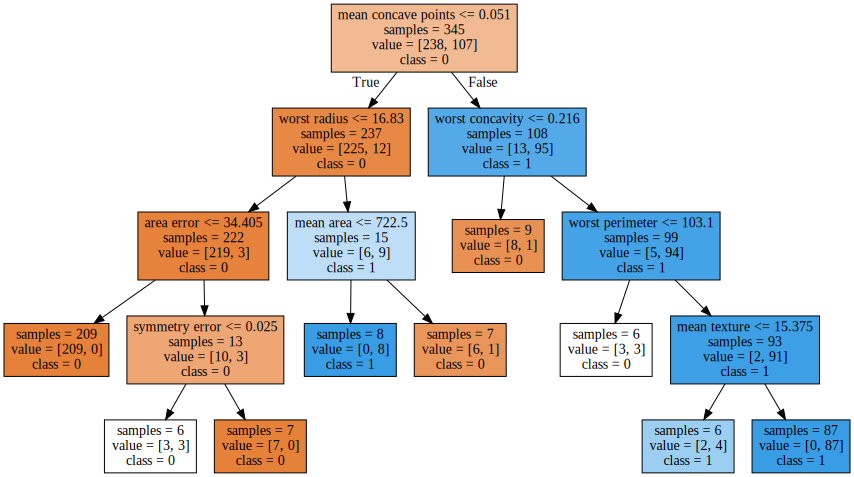

In [55]:
print("RandomForest_Accuracy: {0:.3f}".format(finalModel.score(ds_bc_test_x,ds_bc_test_y).round(3)))

#트리모델 생성, criterion = "gini", max_depth = 4, n_estimators = 15 , min_samples_leaf = 6으로 모델 생성
tree = DecisionTreeClassifier(criterion="gini",max_depth=4,
                            min_samples_leaf=6,random_state=1234)
tree.fit(ds_bc_train_x,ds_bc_train_y)

print("DecisionTree_Accuracy: {0:.3f}".format(tree.score(ds_bc_test_x,ds_bc_test_y).round(3)))


export_graphviz(tree,out_file="tree.dot", class_names=["0","1"],
              feature_names=ds_bc_train_x.columns,impurity=False,filled=True)
os.environ["PATH"] += os.pathsep +""

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#  DT는 그래픽 참고용이지 실제 RF 해석과 무관
#  -------------------------------------------------------------------------------------

# 여러 parameter를 변경하면서 정확도를 개선
# criterion="gini",max_depth=4, min_samples_leaf=6,  n_estimators = 15을 선택
# 0.953의 정확도를 가진 RF 모형
#  
# depth가 커지면 정확도는 올라가나 모델 자체가 복잡해져 일반성이 약해짐
# 위의 해당 모델은 depth가 적당함 

#  min_samples_leaf가 커지면 일반성이 증가하나
# 정확도를 위해 최소 리프가 6임


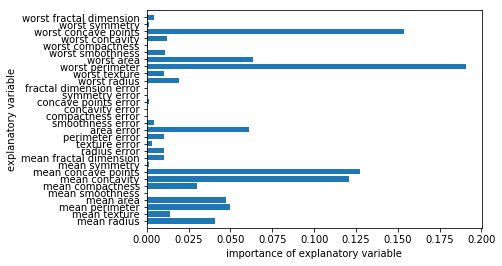

In [57]:
rf_model = RandomForestClassifier(criterion = "gini", max_depth = 4, 
                                    n_estimators = 15 , min_samples_leaf = 6, random_state = 1234)
rf_model.fit(ds_bc_train_x, ds_bc_train_y)

feature_importance = pd.DataFrame()
feature_importance["feature"] = ds_bc_train_x.columns
feature_importance["importance"] = rf_model.feature_importances_
feature_importance.sort_values( by = "importance" , ascending = False)

def plot_feature_importance(model):
    n_features = ds_bc_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_ , align= "center")
    plt.yticks(np.arange(n_features), ds_bc_train_x.columns)
    plt.xlabel("importance of explanatory variable")
    plt.ylabel("explanatory variable")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf_model)

In [58]:
# f설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = ds_bc_train_x.columns
ds_feature_importance["Importance"] = searchcv.feature_importances_
# mportance 테이블을 중요도별로 정렬
ds_feature_importance.sort_values("Importance", ascending=False).head(9)

,Feature,Importance
27,worst concave points,0.2
6,mean concavity,0.2
7,mean concave points,0.2
23,worst area,0.2
22,worst perimeter,0.2
0,mean radius,0.0
16,concavity error,0.0
28,worst symmetry,0.0
26,worst concavity,0.0


#  ----------------------------------------------------

# 5개의 변수로 3개씩 해서 트리가 총 15개가 겹친 것으로 추정